# Phase 2 : Feature Engineering (code de Valentine pour l'instant)

In [1]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


In [2]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
print("Chargement du dataset...")
df = pd.read_csv("../data/processed/NIGERIA_WFP_ADMIN1.csv")

# Conversion Unités (Flux -> mm/mois)
if 'Rainf_f_tavg' in df.columns:
    if df['Rainf_f_tavg'].mean() < 1: 
        df['Rainfall_mm'] = df['Rainf_f_tavg'] * 86400 * 30.4
    else:
        df['Rainfall_mm'] = df['Rainf_f_tavg']




Chargement du dataset...


1. Donnees brutes chargees : 973 lignes
2. Apres Feature Engineering : 887 lignes
   -> Lignes perdues : 86 (Correspond aux 3 derniers mois uniquement)

--- DEMARRAGE DU CHECK-UP ---
[ATTENTION] Il reste 23 valeurs manquantes.
target_plus_3m        0
Rainf_f_tavg_lag6     0
vim_roll3m_mean      23
dtype: int64
[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).


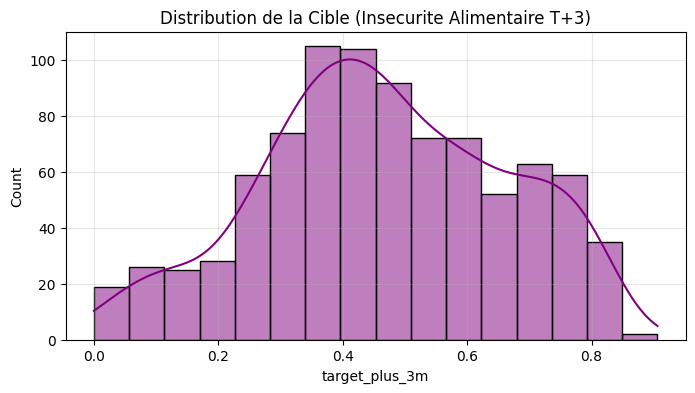


Fichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
try:
    df = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
    df['time'] = pd.to_datetime(df['time'])
    print(f"1. Donnees brutes chargees : {df.shape[0]} lignes")

    # ==============================================================================
    # 2. FEATURE ENGINEERING (Lags et Rolling windows)
    # ==============================================================================
    def create_features_optimized(df):
        # Tri indispensable par Etat et Date
        df = df.sort_values(by=['NAME_1', 'time']).reset_index(drop=True)
        
        # A. Saisonnalite
        df['month'] = df['time'].dt.month
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        
        # B. Lags & Rolling (Decalages et Moyennes)
        cols_meteo = ['Rainf_f_tavg', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 
                      'Tair_f_tavg', 'Evap_tavg', 'Wind_f_tavg', 'SoilTemp00_10cm_tavg']
        cols_ndvi = ['vim', 'viq']
        
        cols_to_process = cols_meteo + cols_ndvi
        cols_existantes = [c for c in cols_to_process if c in df.columns]

        for col in cols_existantes:
            # Rolling (Moyennes Glissantes)
            for window in [3, 6]:
                col_name = f'{col}_roll{window}m_mean'
                # Calcul de la moyenne sur les mois precedents
                df[col_name] = df.groupby('NAME_1')[col].shift(1).rolling(window=window).mean()
                
                # REMPLISSAGE (Backfill) : On remplit les valeurs manquantes du debut 
                # avec la premiere valeur valide disponible pour ne pas perdre de lignes.
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

            # Lags (Decalages simples)
            for lag in [1, 3, 6]:
                col_name = f'{col}_lag{lag}'
                df[col_name] = df.groupby('NAME_1')[col].shift(lag)
                
                # REMPLISSAGE (Backfill)
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

        # C. Targets (Cibles Futures)
        # On ne remplit pas ici car on ne peut pas inventer le futur.
        for horizon in [1, 3]:
            df[f'target_plus_{horizon}m'] = df.groupby('NAME_1')['inadequate'].shift(-horizon)

        # D. Nettoyage Final
        # On ne supprime que les lignes ou la CIBLE manque (les 3 derniers mois)
        df_final = df.dropna(subset=['target_plus_3m'])
        
        return df_final

    # Execution
    df_engineered = create_features_optimized(df)
    print(f"2. Apres Feature Engineering : {df_engineered.shape[0]} lignes")
    perte = df.shape[0] - df_engineered.shape[0]
    print(f"   -> Lignes perdues : {perte} (Correspond aux 3 derniers mois uniquement)")


    # ==============================================================================
    # 3. QUALITY CHECK (VERIFICATION)
    # ==============================================================================
    print("\n--- DEMARRAGE DU CHECK-UP ---")
    
    # Check 1: Valeurs Manquantes (NaNs)
    cols_check = ['target_plus_3m', 'Rainf_f_tavg_lag6', 'vim_roll3m_mean']
    cols_exist = [c for c in cols_check if c in df_engineered.columns]
    nans = df_engineered[cols_exist].isna().sum().sum()
    
    if nans == 0:
        print("[SUCCES] Aucun NaN dans les colonnes critiques.")
    else:
        print(f"[ATTENTION] Il reste {nans} valeurs manquantes.")
        print(df_engineered[cols_exist].isna().sum())

    # Check 2: Coherence Temporelle (Target Shift)
    etat = df_engineered['NAME_1'].unique()[0]
    df_zone = df_engineered[df_engineered['NAME_1'] == etat].sort_values('time')
    
    if len(df_zone) > 10:
        idx = 10
        row = df_zone.iloc[idx]
        date_t = row['time']
        target_stored = row['target_plus_3m']
        
        date_target = date_t + pd.DateOffset(months=3)
        row_target = df_zone[df_zone['time'] == date_target]
        
        if not row_target.empty:
            actual_val = row_target['inadequate'].values[0]
            diff = abs(target_stored - actual_val)
            
            if diff < 1e-4:
                print(f"[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).")
            else:
                print(f"[ECHEC] Incoherence temporelle (Diff: {diff})")
        else:
            print("Info : Impossible de verifier le futur pour cette date (hors limites)")

    # Check 3: Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_engineered['target_plus_3m'], kde=True, color='purple')
    plt.title('Distribution de la Cible (Insecurite Alimentaire T+3)')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Sauvegarde
    df_engineered.to_csv('NIGERIA_WFP_ENGINEERED.csv', index=False)
    print("\nFichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv")

except Exception as e:
    print(f"Erreur : {e}")

Chargement des données...
Période couverte : 2023-01-01 au 2025-09-01


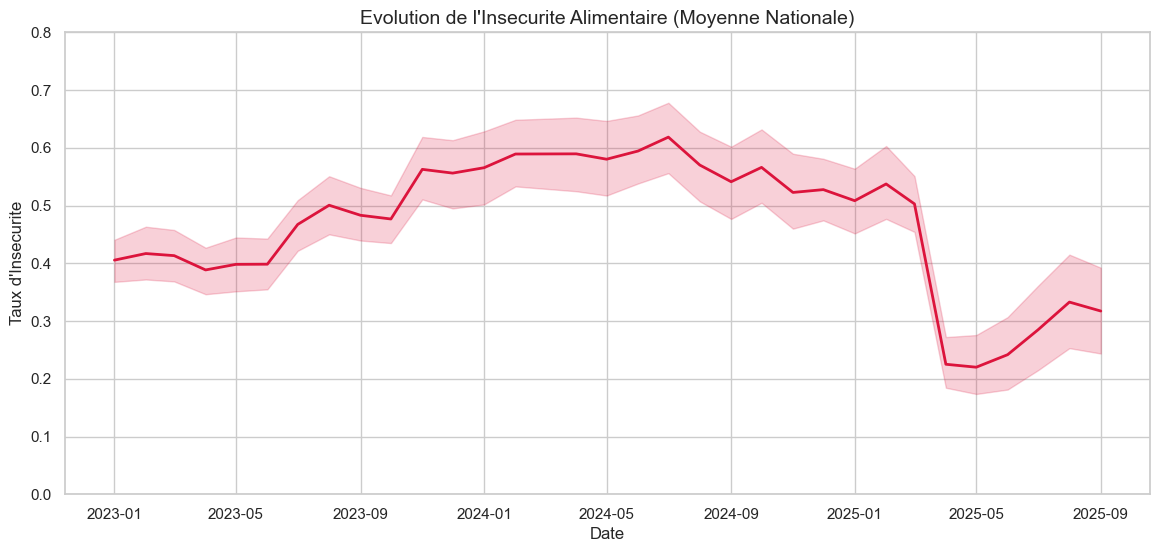

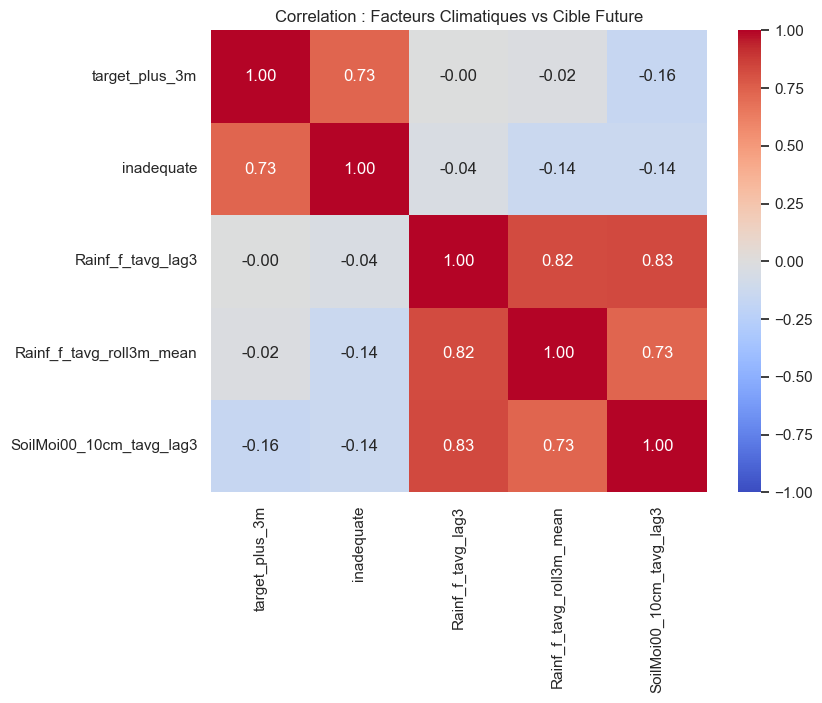

C:\Users\valen\AppData\Local\Temp\ipykernel_1332\965494349.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_avg.values, y=state_avg.index, palette='Reds_r')


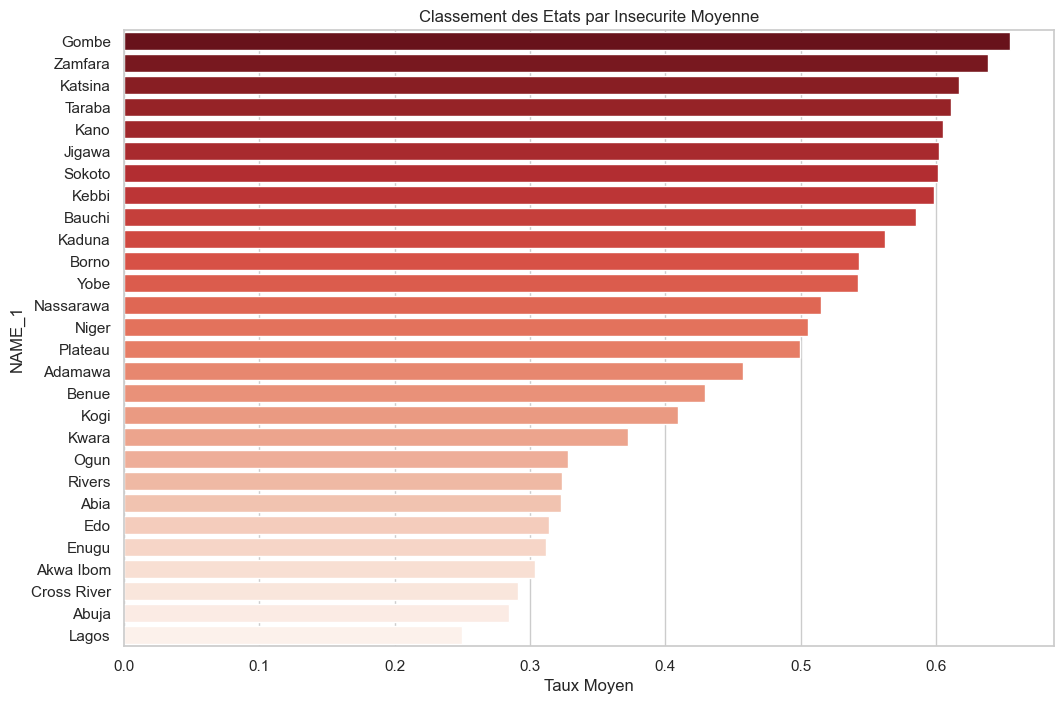

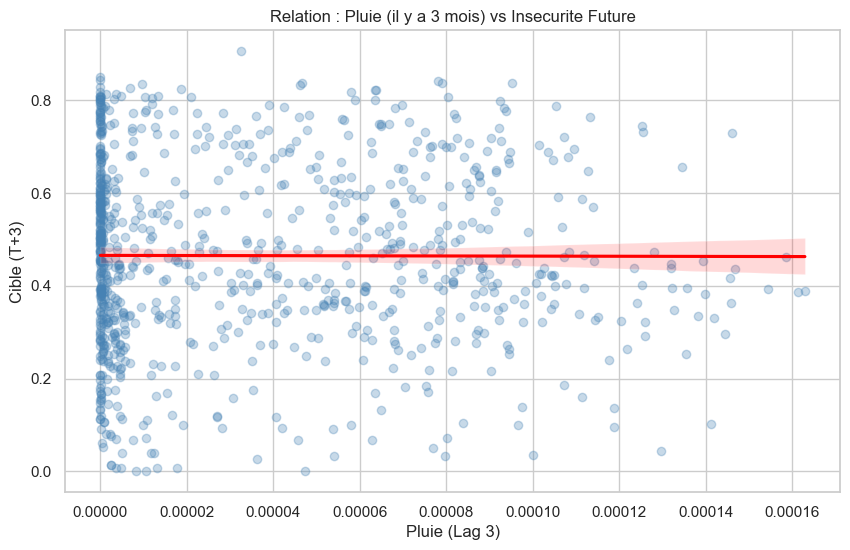

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Chargement du fichier engineered
print("Chargement des données...")
df = pd.read_csv('../data/processed/NIGERIA_WFP_ENGINEERED.csv')
df['time'] = pd.to_datetime(df['time'])

print(f"Période couverte : {df['time'].min().date()} au {df['time'].max().date()}")

# ==============================================================================
# 1. EVOLUTION TEMPORELLE (Saisonnalité)
# ==============================================================================
plt.figure(figsize=(14, 6))
# On trace la moyenne nationale
sns.lineplot(data=df, x='time', y='inadequate', color='crimson', linewidth=2)

plt.title('Evolution de l\'Insecurite Alimentaire (Moyenne Nationale)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Taux d\'Insecurite')
plt.ylim(0, 0.8)
plt.show()

# ==============================================================================
# 2. MATRICE DE CORRELATION
# ==============================================================================
# On selectionne les variables cles (Target Future vs Pluie Passee)
# Adapte les noms si besoin selon tes colonnes exactes
cols_corr = [
    'target_plus_3m',            # Cible Future
    'inadequate',                # Cible Actuelle
    'Rainf_f_tavg_lag3',         # Pluie (Lag 3)
    'Rainf_f_tavg_roll3m_mean',  # Pluie (Moyenne 3 mois)
    'SoilMoi00_10cm_tavg_lag3'   # Humidite Sol (Lag 3)
]

# On ne garde que les colonnes qui existent vraiment
cols_exist = [c for c in cols_corr if c in df.columns]

if len(cols_exist) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[cols_exist].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation : Facteurs Climatiques vs Cible Future')
    plt.show()

# ==============================================================================
# 3. DISPARITES REGIONALES (Nord vs Sud)
# ==============================================================================
# Classement des etats par insecurite moyenne
state_avg = df.groupby('NAME_1')['inadequate'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=state_avg.values, y=state_avg.index, palette='Reds_r')

plt.title('Classement des Etats par Insecurite Moyenne')
plt.xlabel('Taux Moyen')
plt.show()

# ==============================================================================
# 4. SCATTER PLOT : PLUIE vs FAIM
# ==============================================================================
if 'Rainf_f_tavg_lag3' in df.columns:
    plt.figure(figsize=(10, 6))
    
    # On utilise regplot pour voir la tendance
    sns.regplot(data=df, x='Rainf_f_tavg_lag3', y='target_plus_3m', 
                scatter_kws={'alpha':0.3, 'color':'steelblue'}, 
                line_kws={'color':'red'})
    
    plt.title('Relation : Pluie (il y a 3 mois) vs Insecurite Future')
    plt.xlabel('Pluie (Lag 3)')
    plt.ylabel('Cible (T+3)')
    plt.show()

# Travail sur la sécheresse

In [ ]:
# ESSAI 

import pandas as pd
import numpy as np

def add_stress_and_seasonality(df):
    print("Ajout des indicateurs de Stress & Saisonnalité basés sur tes colonnes...")
    
    # 1. SAISON DE SOUDURE (LEAN SEASON)
    # Période critique au Nigeria (Juin-Juillet-Août).
    df['is_lean_season'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_harvest_season'] = df['month'].isin([10, 11]).astype(int)
    
    # 2. CALCUL DES ANOMALIES (Z-SCORES)
    # On compare chaque valeur à la "normale" de ce mois pour cet État. : questionnable
    
    vars_config = {
        'Rainf_f_tavg': 'rain',          # Pluie
        'Tair_f_tavg': 'temp',           # Température
        'SoilMoi00_10cm_tavg': 'soil',   # Humidité Sol
        'vim': 'ndvi'                    # Végétation (Santé des cultures)
    }
    
    for col_name, prefix in vars_config.items():
        if col_name in df.columns:
            # On calcule la moyenne et l'écart-type historiques par (État, Mois)
            stats = df.groupby(['NAME_1', 'month'])[col_name].agg(['mean', 'std']).reset_index()
            stats.columns = ['NAME_1', 'month', f'{prefix}_mean', f'{prefix}_std']
            
            # On fusionne
            df = pd.merge(df, stats, on=['NAME_1', 'month'], how='left')
            
            # Calcul Z-Score : (Valeur - Moyenne) / Ecart-Type
            # Le +1e-6 évite la division par zéro dans les mois très secs
            df[f'{prefix}_anomaly'] = (df[col_name] - df[f'{prefix}_mean']) / (df[f'{prefix}_std'] + 1e-6)
            
            # Nettoyage
            df = df.drop(columns=[f'{prefix}_mean', f'{prefix}_std'])

    # 3. CRÉATION DES INDICATEURS DE STRESS (PROXYS)
    
    # A. SÉCHERESSE (Drought Risk)
    # Définition : Pluie très faible (< -1 sigma)
    if 'rain_anomaly' in df.columns:
        df['is_drought'] = (df['rain_anomaly'] < -1.0).astype(int)
        
        # INTERACTION  : Sécheresse PENDANT la soudure
        df['stress_drought_lean'] = df['is_drought'] * df['is_lean_season']
        
        # Interaction continue (nuance l'intensité)
        df['interact_rain_lean'] = df['rain_anomaly'] * df['is_lean_season']


    # B. INONDATION INTELLIGENTE (Smart Flood Risk)
    # L'inondation arrive quand il pleut fort SUR un sol qui ne peut plus boire.
    
    if 'rain_anomaly' in df.columns and 'soil_anomaly' in df.columns:
        # 1. Pluie Forte (> 1.5 sigma)
        heavy_rain = (df['rain_anomaly'] > 1.5).astype(int)
        
        # 2. Sol Saturé (> 1 sigma au-dessus de la normale)
        saturated_soil = (df['soil_anomaly'] > 1.0).astype(int)
        
        # 3. VRAI Risque Inondation = Pluie Forte + Sol Saturé
        df['is_flood_risk'] = heavy_rain * saturated_soil
        
        # Inondation destructrice pendant la récolte
        df['stress_flood_harvest'] = df['is_flood_risk'] * df['is_harvest_season']
        
    elif 'rain_anomaly' in df.columns:
        # Fallback si pas de données sol 
        df['is_flood_risk'] = (df['rain_anomaly'] > 2.0).astype(int)

    # C. STRESS THERMIQUE (Heatwave)
    # Température anormalement élevée (> +1.5 sigma)
    if 'temp_anomaly' in df.columns:
        df['is_heatwave'] = (df['temp_anomaly'] > 1.5).astype(int)
        df['stress_heat_lean'] = df['is_heatwave'] * df['is_lean_season']

    # D. SANTÉ VÉGÉTATION (NDVI)
    # Si la végétation est faible (anomalie négative) pendant la soudure
    if 'ndvi_anomaly' in df.columns:
        df['low_vegetation'] = (df['ndvi_anomaly'] < -1.0).astype(int)
        df['stress_veg_lean'] = df['low_vegetation'] * df['is_lean_season']
        # Interaction continue
        df['interact_ndvi_lean'] = df['ndvi_anomaly'] * df['is_lean_season']

    return df

# --- EXECUTION ---
# Charge ton fichier
df = pd.read_csv('../data/processed/NIGERIA_WFP_ENGINEERED.csv')
df_final = add_stress_and_seasonality(df)

# Sauvegarde
df_final.to_csv('NIGERIA_WFP_FINAL_FEATURES.csv', index=False)
print("Terminé ! Fichier 'NIGERIA_WFP_FINAL_FEATURES.csv' prêt.")
print("Nouvelles variables clés :", ['stress_drought_lean', 'interact_ndvi_lean', 'stress_flood_harvest'])

Ajout des indicateurs de Stress & Saisonnalité basés sur tes colonnes...
Terminé ! Fichier 'NIGERIA_WFP_FINAL_FEATURES.csv' prêt.
Nouvelles variables clés : ['stress_drought_lean', 'interact_ndvi_lean', 'stress_flood_harvest']


Génération du Graphique 1...


C:\Users\valen\AppData\Local\Temp\ipykernel_28060\2076304860.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


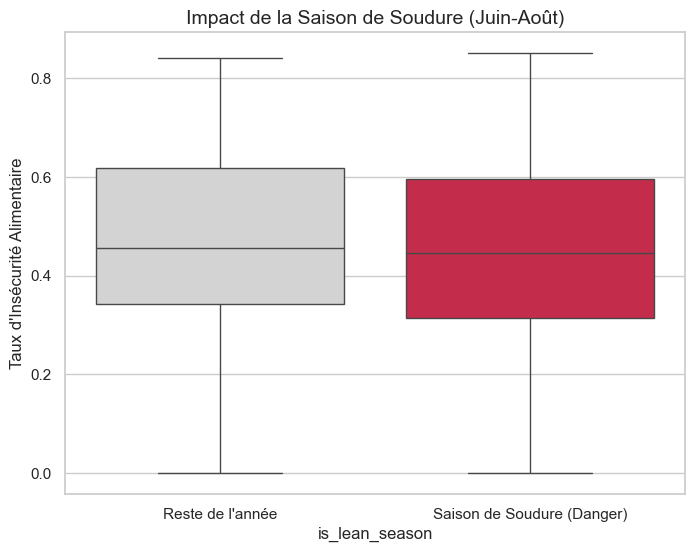

Génération du Graphique 2...


C:\Users\valen\AppData\Local\Temp\ipykernel_28060\2076304860.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


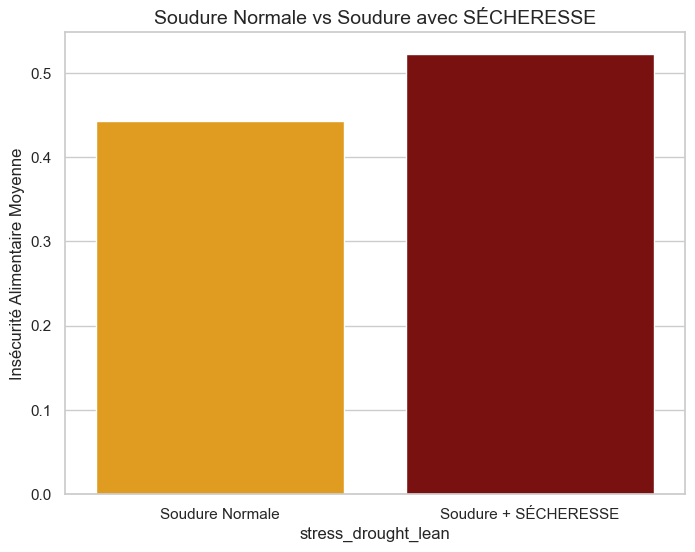

C:\Users\valen\AppData\Local\Temp\ipykernel_28060\2076304860.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Génération du Graphique 3...


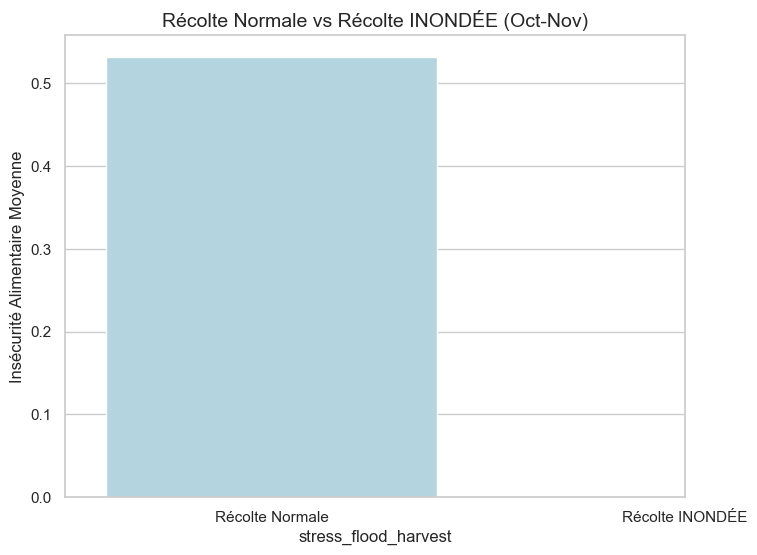

Génération du Graphique 4...


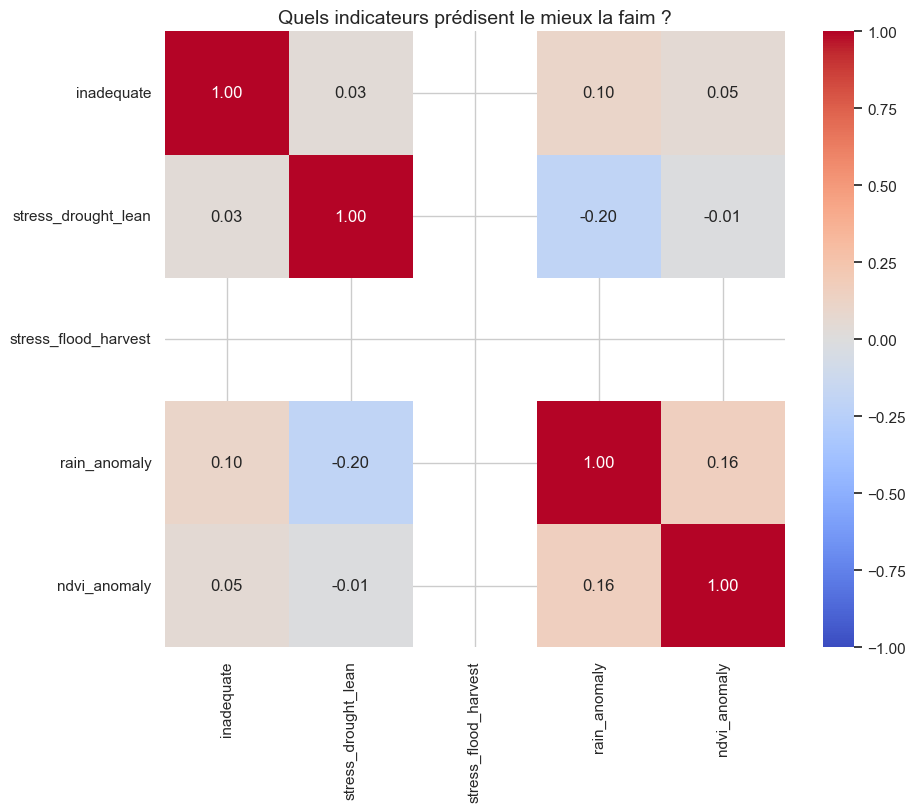

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Chargement (ou utilisation de ton df actuel)
try:
    # On recharge pour être sûr d'avoir un état propre
    df = pd.read_csv('../data/processed/NIGERIA_WFP_FINAL_FEATURES.csv')
except FileNotFoundError:
    print("Fichier introuvable. ")
    df = pd.DataFrame()

if not df.empty:
    # ==============================================================================
    # CONVERSION EN TEXTE (STRING)
    # ==============================================================================
    # On force les colonnes catégorielles en STRING ('0', '1')
    # Cela élimine toute confusion Int/Object pour Seaborn
    cols_to_str = ['is_lean_season', 'stress_drought_lean', 'stress_flood_harvest']
    
    for col in cols_to_str:
        if col in df.columns:
            # D'abord on nettoie en entier, puis on convertit en String
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int).astype(str)


In [ ]:

    # ==============================================================================
    # GRAPHIQUE 1 : L'EFFET "SOUDURE" (LEAN SEASON)
    # ==============================================================================
    print("Génération du Graphique 1...")
    plt.figure(figsize=(8, 6))
    
    # ATTENTION : Les clés du dictionnaire sont maintenant des STRINGS ('0', '1')
    sns.boxplot(
        data=df, 
        x='is_lean_season', 
        y='inadequate', 
        palette={'0': 'lightgrey', '1': 'crimson'} # Clés en texte !
    )
    
    plt.title("Impact de la Saison de Soudure (Juin-Août)", fontsize=14)
    plt.xticks([0, 1], ['Reste de l\'année', 'Saison de Soudure (Danger)'])
    plt.ylabel('Taux d\'Insécurité Alimentaire')
    plt.show()

    # ==============================================================================
    # GRAPHIQUE 2 : IMPACT SÉCHERESSE
    # ==============================================================================
    if 'stress_drought_lean' in df.columns:
        print("Génération du Graphique 2...")
        plt.figure(figsize=(8, 6))
        
        # Filtre sur la soudure ('1' en texte maintenant)
        df_lean = df[df['is_lean_season'] == '1'].copy()
        
        if not df_lean.empty:
            sns.barplot(
                data=df_lean, 
                x='stress_drought_lean', 
                y='inadequate', 
                palette={'0': 'orange', '1': 'darkred'}, # Clés en texte
                errorbar=None
            )
            
            plt.title("Soudure Normale vs Soudure avec SÉCHERESSE", fontsize=14)
            plt.xticks([0, 1], ['Soudure Normale', 'Soudure + SÉCHERESSE'])
            plt.ylabel('Insécurité Alimentaire Moyenne')
            plt.show()

    # ==============================================================================
    # GRAPHIQUE 3 : IMPACT INONDATION RÉCOLTE
    # ==============================================================================
    if 'stress_flood_harvest' in df.columns:
        print("Génération du Graphique 3...")
        plt.figure(figsize=(8, 6))
        
        # Filtre sur la récolte (Assure-toi que is_harvest_season est aussi géré)
        # Pour simplifier, on le recalcule ou on le convertit si présent
        if 'is_harvest_season' in df.columns:
             df['is_harvest_season'] = df['is_harvest_season'].astype(int).astype(str)
             df_harvest = df[df['is_harvest_season'] == '1'].copy()
        else:
             df_harvest = pd.DataFrame()

        if not df_harvest.empty:
            sns.barplot(
                data=df_harvest, 
                x='stress_flood_harvest', 
                y='inadequate', 
                palette={'0': 'lightblue', '1': 'darkblue'}, # Clés en texte
                errorbar=None
            )
            
            plt.title("Récolte Normale vs Récolte INONDÉE (Oct-Nov)", fontsize=14)
            plt.xticks([0, 1], ['Récolte Normale', 'Récolte INONDÉE'])
            plt.ylabel('Insécurité Alimentaire Moyenne')
            plt.show()

    # ==============================================================================
    # GRAPHIQUE 4 : CORRÉLATIONS
    # ==============================================================================
    print("Génération du Graphique 4...")
    
    # Pour la corrélation, il faut revenir aux CHIFFRES !
    # On crée une copie temporaire numérique
    df_num = df.copy()
    for col in cols_to_str:
        if col in df_num.columns:
            df_num[col] = pd.to_numeric(df_num[col])

    cols_expert = [
        'inadequate', 'stress_drought_lean', 'stress_flood_harvest', 
        'rain_anomaly', 'ndvi_anomaly'
    ]
    cols_exist = [c for c in cols_expert if c in df_num.columns]
    
    if len(cols_exist) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_num[cols_exist].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title("Quels indicateurs prédisent le mieux la faim ?", fontsize=14)
        plt.show()